# Choosing Competitors for FMCG Items

## Abstract

This project was initiated at the request of a consulting firm seeking a method to identify the most similar competitors for FMCG products. The purpose was to enable them to monitor these competitors and track their marketing strategies and actions. Consequently, the main objective of this project was to develop a function that could provide such recommendations to the directors. This objective was achieved by following these steps:

1. Creating the initial data frames.
2. Parsing the weight/volume values from product names.
3. Segmenting data by subcategories and consolidating unit values within each subcategory subset.
4. Computing sales-related metrics for each subcategory dataset.
5. Standardizing metrics and performing data binning.
6. Implementing a two-step clustering process.
7. Defining the final competitor extraction function.
8. Conducting Exploratory Data Analysis (EDA) on the results

## 1. Creating the initial data frames

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df_order_main = pd.read_excel('...\\Per_Barcode_per_day_per_vendor.xlsx')

In [ ]:
df_product_main = pd.read_excel('...\\ExpressMaster.xlsx')

In [ ]:
df_order_main
df_order = df_order_main.drop(df_order_main[df_order_main['Barcode']==''].index)

In [ ]:
df_order['sale'] = df_order['#']*df_order['$']

In [ ]:
df_order.fillna('',inplace= True)
df_order['Date']= pd.to_datetime(df_order['Date'])
df_order['VendorID'] = df_order['VendorID'].astype('Int32')
df_order['OrderID'] = df_order['OrderID'].astype('Int32')
df_order['UserID'] = df_order['UserID'].astype('Int32')
df_order['#'] = df_order['#'].astype('int32')
df_order['$'] = df_order['$'].astype('int32')
df_order['sale'] = df_order['sale'].astype('int64')
df_order.columns = ['date','vendorID','orderID','userID','city','barcode','subCat','qty','price','sale']

In [ ]:
df_product = df_product_main.drop(['brandName','menuActive','productActive'], axis=1)
df_product.drop(df_product[df_product['barcode'].isnull()].index, inplace=True)
df_product = df_product[df_product['catName']=='لبنیات و بستنی']

In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
df_product

In [ ]:
df_order

## 2. Parsing the weight/volume values from product names

In [ ]:
df1=df_product['productName'].str.extractall(r'\D*(\d+[.,]?\d*)(\s*)?(گرم)?(gr)?(lit)?(ML)?(Lit)?(ml)?(کیلو)?(میلی)?(لیتر)?( سی )?(سانت)?(عدد)?( تا )?(پاکت)?(ميل)?(ليتر)?(كيلو)?(برگ)?(مثقال)?(بسته)?(باکس)?(جفت)?(mg)?(قطعه)?(نفر)?(متر)?(Kg)?(میل)?(کرم)?(کبلوگرم)?\D*')
df2=df_product['productName'].str.extract(r'\D*(یک)(\s*)?(گرم)?(gr)?(lit)?(ML)?(Lit)?(ml)?(کیلو)?(میلی)?(لیتر)?( سی )?(سانت)?(عدد)?( تا )?(پاکت)?(ميل)?(ليتر)?(كيلو)?(برگ)?(مثقال)?(بسته)?(باکس)?(جفت)?(mg)?(قطعه)?(نفر)?(متر)?(Kg)?(میل)?(کرم)?(کبلوگرم)?\D*')

In [ ]:
df1.index = df1.index.set_names(['first', 'second'])

In [ ]:
df2['productName']= df_product['productName']
df2['productID']= df_product['productID']

In [ ]:
df1 = pd.merge(df1,df2[['productID','productName']],right_index=True, left_on='first', how='inner')

In [ ]:
df1 = df1.reset_index()

In [ ]:
df1.drop(['first','second'],axis=1,inplace=True)

#### Concatenating the unit different values, Deleting rows that are not unit related.

In [ ]:
df1.fillna('', inplace=True)
df2.fillna('', inplace=True)

In [ ]:
df1['unit'] = df1.iloc[:,2]
for i in range(3,32):
    df1['unit'] = df1.iloc[:,i] + df1['unit']
df2['unit'] = df2.iloc[:,2]
for i in range(3,32):
    df2['unit'] = df2.iloc[:,i] + df2['unit']
df1['value'] = df1.iloc[:,0]
df2['value'] = df2.iloc[:,0]

In [ ]:
df1 = df1[['productID','productName','unit','value']]
df2 = df2[['productID','productName','unit','value']]

In [ ]:
df1.drop(df1[df1['unit']==''].index, inplace=True)
df2.drop(df2[df2['unit']==''].index, inplace=True)
df2['value'].replace('یک','1',inplace=True)

In [ ]:
df1

In [ ]:
df2

#### Merging extract final results with each other and the original product df (deleting rows with two products in two dataframes and in the same dataframe)

In [ ]:
df = pd.merge(df1,df2,on='productID',how='outer')
df.fillna('',inplace=True)

In [ ]:
df_concat = df[(df['unit_x']!='') & (df['unit_y']!='')]

In [ ]:
df_same_concat =df[df['productID'].duplicated() & ~df['unit_x'].str.contains('عدد')]

In [ ]:
df = pd.merge(df_product,df, on='productID', how='outer')

In [ ]:
df = df[~df.productID.isin(df_concat.productID)]

In [ ]:
df = df[~df.productID.isin(df_same_concat.productID)]

In [ ]:
df.fillna('',inplace=True)
df.drop(['productName_x','productName_y'],axis=1,inplace=True)

#### Saving rows without units or non-numeric units, replacing with numeric values manually by importing and merging file with dataframe 

In [ ]:
df_null = df[(df['unit_x']=='') & (df['unit_y']=='')]

In [ ]:
df_adad = df[df['unit_x'].str.contains('عدد')]
df_adad = df_adad.append(df[df['unit_y'].str.contains('عدد')])

In [ ]:
df_null.to_excel('...\\without_unit.xlsx')
df_adad.to_excel('...\\adad_unit.xlsx')

In [ ]:
df_units = pd.read_excel('C:...\\Units_Values.xlsx')

In [ ]:
df_units

In [ ]:
df['value_x'] = df['value_x'] + df['value_y']
df['unit_x'] = df['unit_x'] + df['unit_y']

#### Removing rows without units, with non-numeric units

In [ ]:
df = df[~df.productID.isin(df_adad.productID)]

In [ ]:
df = df[~df.productID.isin(df_null.productID)]

In [ ]:
df[['barcode','unit_x']] = df[['barcode','unit_x']].astype('object')
df_units[['barcode','unit']] = df_units[['barcode','unit']].astype('object')

In [ ]:
df = pd.merge (df , df_units, 
               left_on=['productID','productName','barcode','subCatID','subCatName','catName'],
               right_on=['productID','productName','barcode','subCatID','subCatName','catName'],
               how='outer')

In [ ]:
df.fillna('',inplace=True)

In [ ]:
condition1 = [(df['value']==''),(df['value']!='')]
choices = [df.loc[:,'value_x'], df.loc[:,'value']]
df['value'] = np.select(condition1,choices, default=0)
condition2 = [(df['unit']==''),(df['unit']!='')]
choices = [df.loc[:,'unit_x'], df.loc[:,'unit']]
df['unit'] = np.select(condition2,choices, default=0)
df.drop(['unit_x','value_x','unit_y','value_y','Unnamed: 0'], axis=1, inplace=True)
df['value'] = df['value'].astype('float')

In [ ]:
df.info()

## 3. Segmenting data by subcategories and consolidating unit values

#### Split Data due to Subcategory

In [ ]:
dtf = [d for _, d in df.groupby(['subCatID'])]

### Getting the units of each product and uniting all row's units (numeric ones) for each subcategory subset.

In [ ]:
for i in range(0,len(dtf)):
    dtf[i].fillna('',inplace=True)
    dtf[i]['productID'] = dtf[i]['productID'].astype('Int32')
    dtf[i]['subCatID'] =  dtf[i]['subCatID'].astype('Int32')
    print('subcat Number%s'%i)
    print(dtf[i].subCatName.unique())
    print(dtf[i].subCatID.unique())
    print(dtf[i].unit.unique())

In [ ]:
for i in range(0,len(dtf)):
    if dtf[i].subCatName.unique() == ['شیر'] or dtf[i].subCatName.unique() == ['لبنیات گیاهی']:
        conditions = [(dtf[i]['unit'] == 'لیتر'),(dtf[i]['unit'] == 'میلی\u200cلیتر'),(dtf[i]['unit'] == 'میلی لیتر'),
                      (dtf[i]['unit'] == 'گرم'),(dtf[i]['unit'] == 'لیترمیلی'),(dtf[i]['unit'] == 'میل'),(dtf[i]['unit'] == 'میلی'),
                      (dtf[i]['unit'] == 'کیلو')]
        choices = [dtf[i]['value']*1000, dtf[i]['value'], dtf[i]['value'], dtf[i]['value'], dtf[i]['value'], dtf[i]['value'],
                   dtf[i]['value'],dtf[i]['value']*1000]
        dtf[i]['unit'] = 'میلی لیتر'
    elif dtf[i].subCatName.unique() == ['بستنی و فالوده']:
        conditions = [(dtf[i]['unit'] == 'گرم'),(dtf[i]['unit'] == 'لیتر'), (dtf[i]['unit'] == 'کیلو'),(dtf[i]['unit'] == 'میلی')]
        choices = [dtf[i]['value'] , dtf[i]['value']*554, dtf[i]['value']*1000, dtf[i]['value']*0.554]
        dtf[i]['unit'] = 'گرم'
    else:
        conditions = [(dtf[i]['unit'] == 'گرم'),(dtf[i]['unit'] == 'کیلو'),(dtf[i]['unit'] == 'کبلوگرم'),
                   (dtf[i]['unit'] == 'میلی'),(dtf[i]['unit'] == 'کیلوگرم'),(dtf[i]['unit'] == 'لیتر'),(dtf[i]['unit'] == 'کرم')]
        choices = [dtf[i]['value'],dtf[i]['value']*1000,dtf[i]['value']*1000, dtf[i]['value'],
                dtf[i]['value']*1000, dtf[i]['value']*1000,dtf[i]['value']]
        dtf[i]['unit'] = 'گرم'
    dtf[i]['value'] = np.select(conditions,choices, default=0)

## 4. Computing sales-related metrics for each subcategory dataset

In [ ]:
df_order['totalSale'] = df_order.groupby('barcode')['sale'].transform('sum')
df_order['avgPrice'] = df_order.groupby('barcode')['price'].transform('mean')
df_order.avgPrice = df_order.avgPrice.round()
df_order['storeTurnover'] = df_order.groupby('vendorID')['sale'].transform('sum')
df_order['productStoreTurnover'] = df_order.groupby('barcode')['storeTurnover'].transform('sum')
df_order['customerNum'] = df_order.groupby('barcode')['userID'].transform('nunique')
df_order['customerNum'] = df_order['customerNum'].astype('Int32')
df_order['avgPrice'] = df_order['avgPrice'].astype('Int32')
df_join = df_order.drop_duplicates('barcode')

In [ ]:
df_order

In [ ]:
for i in range(0,len(dtf)):
    dtf[i] = dtf[i].merge(df_join[['totalSale','productStoreTurnover','barcode','avgPrice','customerNum']], how='left', on='barcode')
    dtf[i].drop(dtf[i][dtf[i]['productID'].isnull()].index,inplace=True)
    dtf[i].drop(dtf[i][dtf[i]['totalSale'].isnull()].index,inplace=True)
    dtf[i]['marketShare'] = dtf[i]['totalSale']/(dtf[i]['totalSale'].sum())
    dtf[i]['penetration'] = dtf[i]['customerNum']/(dtf[i]['customerNum'].sum())
    dtf[i]['wghtDist'] = dtf[i]['productStoreTurnover']/(dtf[i]['productStoreTurnover'].sum())
    dtf[i].fillna('',inplace=True)
    dtf[i].reset_index(drop=True,inplace=True)

In [ ]:
for i in range(0,len(dtf)):
    print(dtf[i].shape)

## 5. Standardizing metrics and performing data binning

In [ ]:
group_names = ['very_low','low','medium','high','very_high']    
for i in range(0,len(dtf)):
    dtf[i]['n_value'] = dtf[i]['value']/dtf[i]['value'].sum()
    dtf[i]['n_avgPrice'] = dtf[i]['avgPrice']/dtf[i]['avgPrice'].sum()
    bins = np.linspace(min(dtf[i]['totalSale']), max(dtf[i]['totalSale']),6)
    dtf[i]['totalSale_binned']= pd.cut(dtf[i]['totalSale'],bins, labels = group_names, include_lowest=True)
    bins = np.linspace(min(dtf[i]['value']), max(dtf[i]['value']),6)
    dtf[i]['value_binned']= pd.cut(dtf[i]['value'],bins, labels = group_names, include_lowest=True)
    bins = np.linspace(min(dtf[i]['avgPrice']), max(dtf[i]['avgPrice']),6)
    dtf[i]['avgPrice_binned']= pd.cut(dtf[i]['avgPrice'],bins, labels = group_names, include_lowest=True)

## 6. Implementing a two-step clustering process

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_6 = KMeans(n_clusters = 6)
kmeans_3= KMeans(n_clusters=3)
kmeans_2 = KMeans(n_clusters=2)

In [ ]:
label={}
label_2={}
for i in range(0,len(dtf)):
    if dtf[i].subCatName.unique() == ['شیر'] or dtf[i].subCatName.unique() == ['ماست'] or dtf[i].subCatName.unique() == ['پنیر'] or dtf[i].subCatName.unique() == ['بستنی و فالوده']:
        kmeans_6.fit(dtf[i][['n_value','n_avgPrice']])
        label[i]= kmeans_6.labels_
    else:
        kmeans_3.fit(dtf[i][['n_value','n_avgPrice']])
        label[i]= kmeans_3.labels_
    dtf[i]['cluster'] = label[i]
    dtf[i]['cluster_2']=np.nan
    for j in range(0,len(label[i])):
        if len(dtf[i][dtf[i]['cluster']==j])>2:
            kmeans_3.fit(dtf[i][['marketShare','penetration','wghtDist']][dtf[i]['cluster']==j])
            label_2[i]=kmeans_3.labels_
            dtf[i]['cluster_2'][dtf[i]['cluster']==j] = label_2[i]
            dtf[i]['cluster_2'].fillna(0,inplace=True)
            dtf[i]['cluster_2'] = dtf[i]['cluster_2'].astype('int32')
        else:
            dtf[i]['cluster_2'][dtf[i]['cluster']==j] =0
            dtf[i]['cluster_2'].fillna(0,inplace=True)
            dtf[i]['cluster_2'] = dtf[i]['cluster_2'].astype('int32')

In [ ]:
final_df=pd.DataFrame()
for i in range(0,len(dtf)):
    final_df = final_df.append(dtf[i],ignore_index=True)

In [ ]:
final_df

In [ ]:
finalResults={}
for i in range(0,8):
    finalResults[i] = dtf[i][['productName','avgPrice','value','marketShare','penetration','wghtDist','unit','cluster','cluster_2']]
    finalResults[i] = finalResults[i].sort_values(by='cluster')
    finalResults[i].to_excel('...\\ProductCluster_SubCat(%s).xlsx'%i)

## 7. Defining the final competitor extraction function

In [65]:
def product_name_extraction(name):
    result = final_df['productName'][final_df['productName'].str.contains(name)]
    print(result)

In [66]:
def cluster_extraction(productName):
    ext_index=final_df[final_df['productName']==productName].index.item()
    ext_subCat = final_df.at[ext_index,'subCatName']
    ext_cluster = final_df.at[ext_index,'cluster']
    ext_cluster_2 = final_df.at[ext_index,'cluster_2']
    ext_df=final_df[(final_df['subCatName']==ext_subCat)&(final_df['cluster']==ext_cluster)&(final_df['cluster_2']==ext_cluster_2)]
    ext_df=ext_df[['productName','value','unit','marketShare','penetration','wghtDist']].sort_values(by='marketShare').reset_index(drop=True)
    index=ext_df[ext_df['productName']==productName].index.item()
    result = ext_df[index-2:index+4][:]
    print(result.to_string(index=False))

In [67]:
product_name_extraction('سون')

354        ماست کم‌چرب 1.5٪ سون کاله (500 گرم)
399     ماست پرچرب 4٪ پرشین سون کاله (900 گرم)
400        ماست موسیر پرچرب سون کاله (900 گرم)
492    ماست همزده پرچرب سون کاله (2.2 کیلوگرم)
496    ماست همزده پرچرب سون کاله (1.5 کیلوگرم)
534         ماست کم‌چرب سون کاله (1.5 کیلوگرم)
535             ماست کم‌چرب سون کاله (900 گرم)
536    ماست کم‌چرب 2.5٪ سون کاله (2.2 کیلوگرم)
537           ماست پرچرب 5٪ سون کاله (900 گرم)
608           ماست پرچرب 4٪ سون کاله (900 گرم)
609           ماست پرچرب 4٪ سون کاله (500 گرم)
759              ماست پرچرب سون کاله (450 گرم)
Name: productName, dtype: object


In [68]:
cluster_extraction('ماست پرچرب 4٪ پرشین سون کاله (900 گرم)')

                           productName  value unit  marketShare  penetration  wghtDist
ماست نیم‌چرب محلی شیراز رامک (900 گرم)  900.0  گرم     0.000806     0.000812  0.000685
             ماست چکیده هراز (750 گرم)  750.0  گرم     0.001130     0.001191  0.001128
ماست پرچرب 4٪ پرشین سون کاله (900 گرم)  900.0  گرم     0.001198     0.001029  0.000809
      ماست موسیر چکیده چوپان (500 گرم)  500.0  گرم     0.001209     0.001029  0.001094
        ماست چکیده محلی هراز (900 گرم)  900.0  گرم     0.001254     0.000704  0.000926
     ماست گاو‌میش پرچرب پگاه (800 گرم)  800.0  گرم     0.001306     0.001083  0.001473


## 8. Conducting Exploratory Data Analysis (EDA) on the results

In [69]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=8,4

In [ ]:
final_df.info()

In [ ]:
final_df

In [ ]:
df_order

### Scatter plot of clustering metrics

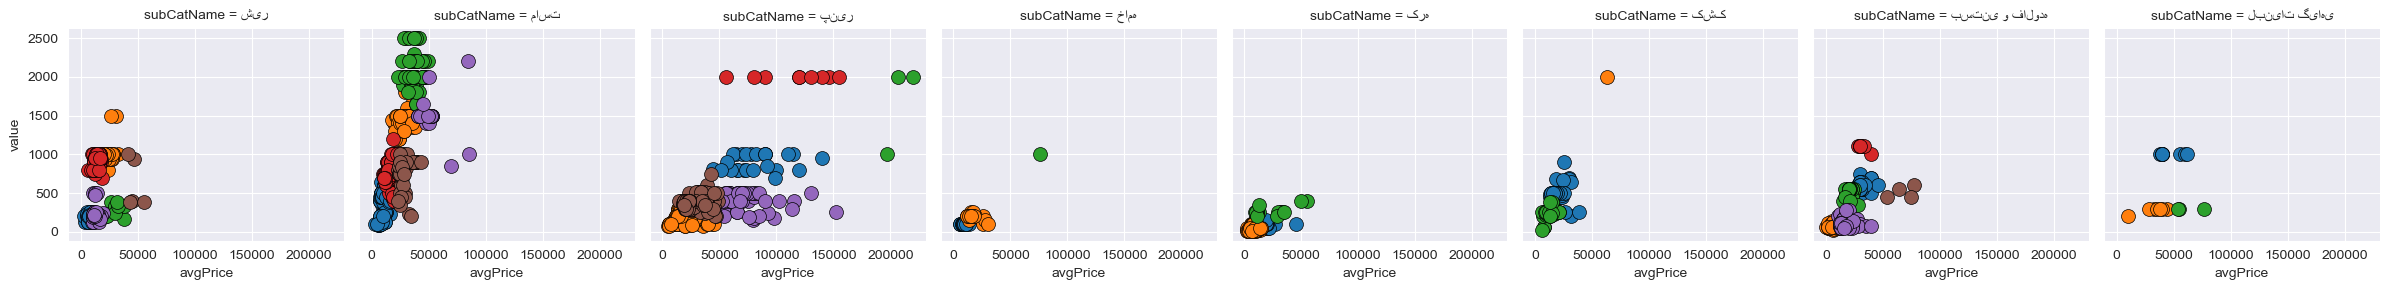

In [70]:
g = sns.FacetGrid(final_df, col='subCatName' ,hue='cluster')
kws=dict(s=100, linewidth=0.5, edgecolor='black')
g= g.map(plt.scatter, 'avgPrice', 'value',**kws)

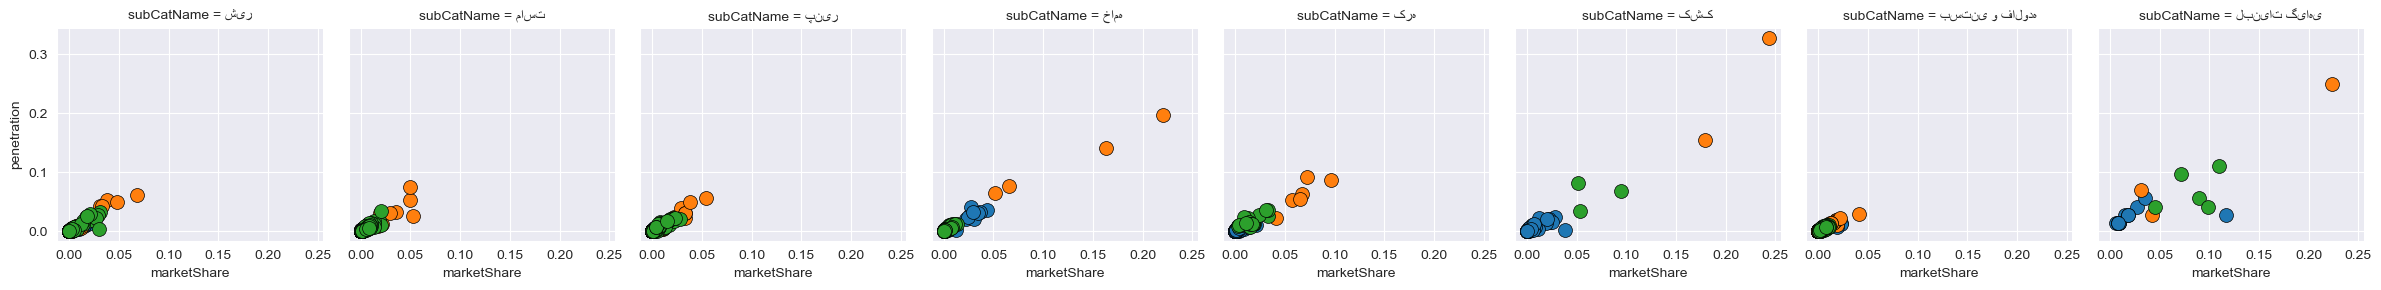

In [72]:
g = sns.FacetGrid(final_df, col='subCatName' ,hue='cluster_2')
kws=dict(s=100, linewidth=0.5, edgecolor='black')
g= g.map(plt.scatter, 'marketShare', 'penetration',**kws)

#### Vendor-Num of orders

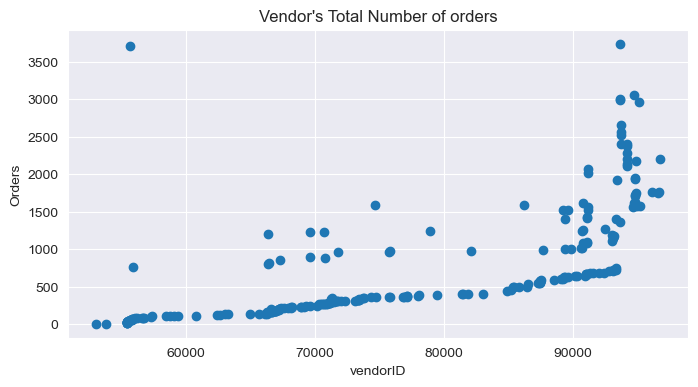

In [73]:
plt.scatter(x = df_order.vendorID.unique(), y =df_order.groupby('vendorID').agg({'orderID':pd.Series.nunique}).sort_values('orderID'))
plt.xlabel("vendorID") 
plt.ylabel("Orders") 
plt.title("Vendor's Total Number of orders") 
plt.show()

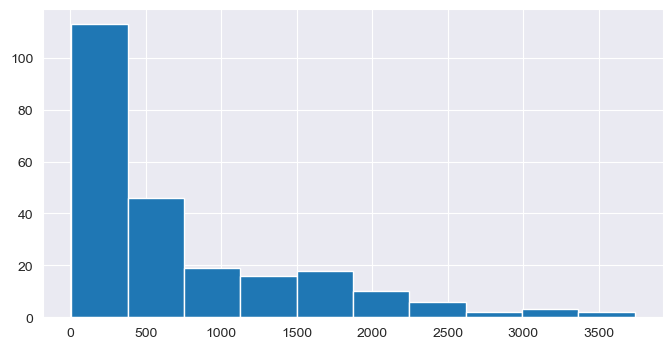

In [74]:
plt.hist(x = df_order.groupby('vendorID').agg({'orderID':pd.Series.nunique}).sort_values('orderID'))
plt.show()

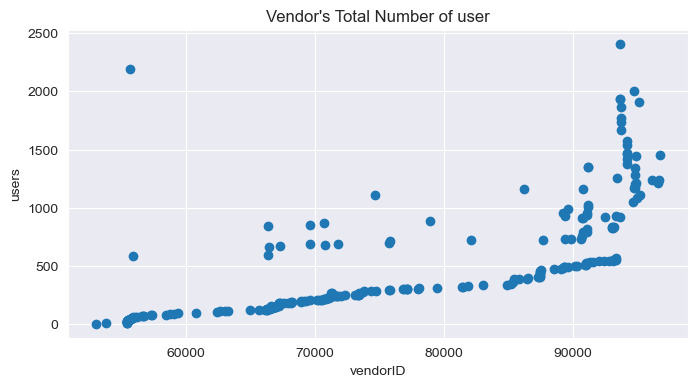

In [75]:
plt.scatter(x = df_order.vendorID.unique(), y =df_order.groupby('vendorID').agg({'userID':pd.Series.nunique}).sort_values('userID'))
plt.xlabel("vendorID") 
plt.ylabel("users") 
plt.title("Vendor's Total Number of user") 
plt.show()

In [77]:
df_grp = dtf[0][['value_binned','avgPrice_binned','totalSale']].groupby(['value_binned','avgPrice_binned'],as_index=False).sum()
df_grp['totalSale'] = df_grp['totalSale'].astype('int32')
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   value_binned     25 non-null     category
 1   avgPrice_binned  25 non-null     category
 2   totalSale        25 non-null     int32   
dtypes: category(2), int32(1)
memory usage: 702.0 bytes


In [78]:
df_pivot = df_grp.pivot(index='value_binned',columns='avgPrice_binned')
df_pivot

totalSale                                        
avgPrice_binned   very_low        low    medium     high very_high
value_binned                                                      
very_low         208416496   47523750  21246000  2608700    100000
low                3330150     600000         0        0         0
medium            82338778  257207261   1801700        0     93200
high               1192125  309116985  27495460   690000         0
very_high                0          0   1935600        0         0

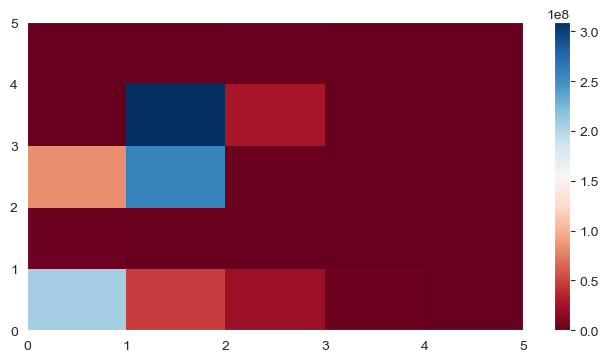

In [79]:
plt.pcolor(df_pivot, cmap='RdBu')
plt.colorbar()
plt.show()